<h3> SIS model </h3>

Эта модель много изучалась в эпидимиологии. SIS model расшифровывается как Suspectible Infected Suspectible. Похожа на модель распространения вируса в компьютерной сети: вы поймали вирус, потом его стерли с компьютера, потом снова поймали, потом снова стерли и так далее. 
Давайте представим, что у нас есть социальная сеть, на подобии Твиттера. И вы хотите оценить по твитам, сколько людей болеет, например гриппом, сейчас. И предположим, что х ведет себя как цепь Маркова, зависящая от состояния s, причем вероятность агента перейти в другое состояние(выздороветь или заболеть) зависит от того, в каком состоянии он был до этого, от того сколько агентов заражено рядом с ним и : <p>
$ \mathbb{P}(x^{(m)}_{k + 1} = j | x^{(m)}_k,  A^{(m)}_k, s_k = s) = p_{ij}(d,A^{(m)}_k, s) $, где <p>
$ A^{(m)}_k $ - сколько агентов заражено рядом с агентом k  в момент времени x. <p>
Let $x^{(m)}_k \in {0, 1} $ denote your state:<p>
$x^{(m)}_k = 0$, if the agent is suspectibe <p> and 
$x^{(m)}_k = 1$, if the agent is infected
    
Определим infected node probability $\rho_k(d) $ is probability of node d is infected: <p>
    $\rho_k(d)$ = $ \frac{1}{N} \sum_{m \in V}{ I \{ D^{(m)} = d, x^{(m)}_k = 1} \} $ <p>
Определим infected link probability $\theta_k(\rho_k)$ as as the probability that at time k a uniformly sampled link in the network points to an infected node. <p>
Определим scaled transition probabilities of the process $\rho$ are: <p>
    $\overline{p}_{01}(d, \theta_k, s) = \frac{1}{P(d)} \mathbb{P}(\rho_{k + 1}(d) = \rho_k(d) + \frac{1}{N(d)} | s_k = s) $ <p>
    $\overline{p}_{10}(d, \theta_k, s) = \frac{1}{P(d)} \mathbb{P}(\rho_{k + 1}(d) = \rho_k(d) - \frac{1}{N(d)} | s_k = s) $ <p>
    Зная довольно общую информацию о графе и процессе(распределение степеней вершин графа, примерное количество заболевших), вы знаете поведение процесса во времени далее, если число агентов в сети достаточно далеко. Это поведение хорошо описывает система уравнений "Mean field dynamics of information diffusion."
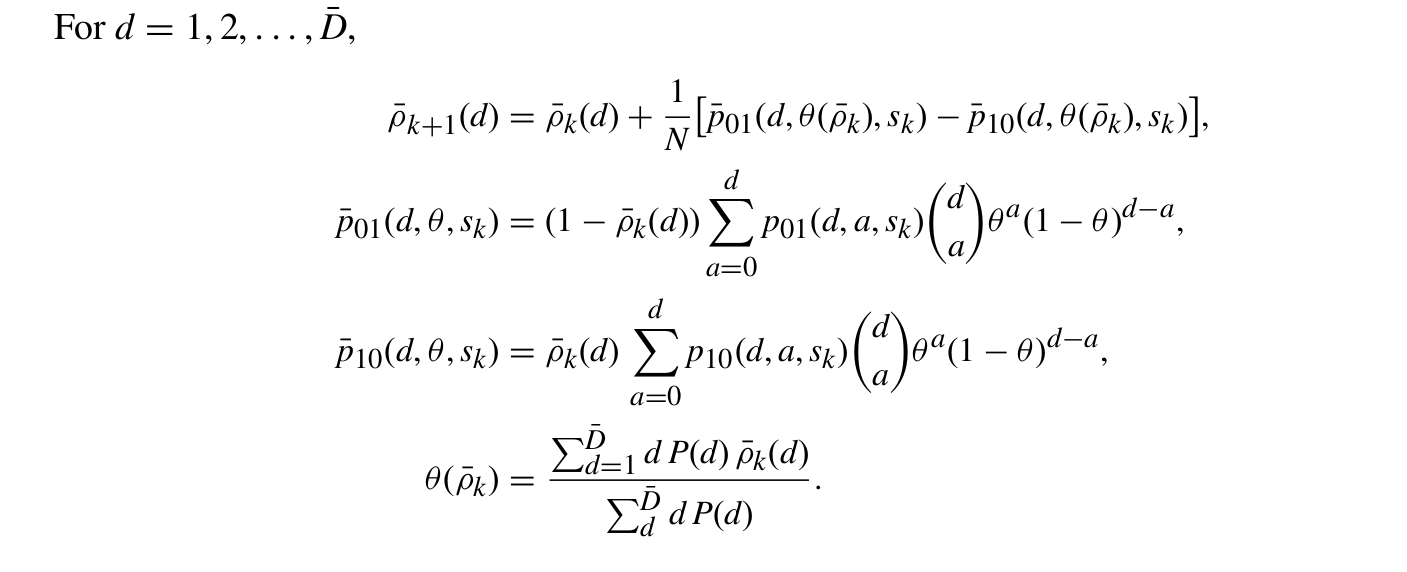

    
Собственно, проверке этого утверждения и посвящен этот ноутбук. На графике Theoretical estimate - вы видите infected link probability, которое следует из этого уравнения, а на графике Real infected link probability вы видите реальное проведение $\theta_k$. Видны отличия: возможно это связано с тем, что число агентов не так уж велико(всего лишь 100), возможно ошибка в программе. Однако, это все равно довольно близко. 
Эта модель может быть использована для оценки количества заболевших гриппов, на основе твитов в Twitter. 
    
Подробнее вы можете прочитать об этом в книге "Cooperative and graph signal processing" chapter 21.

Iteration :  10

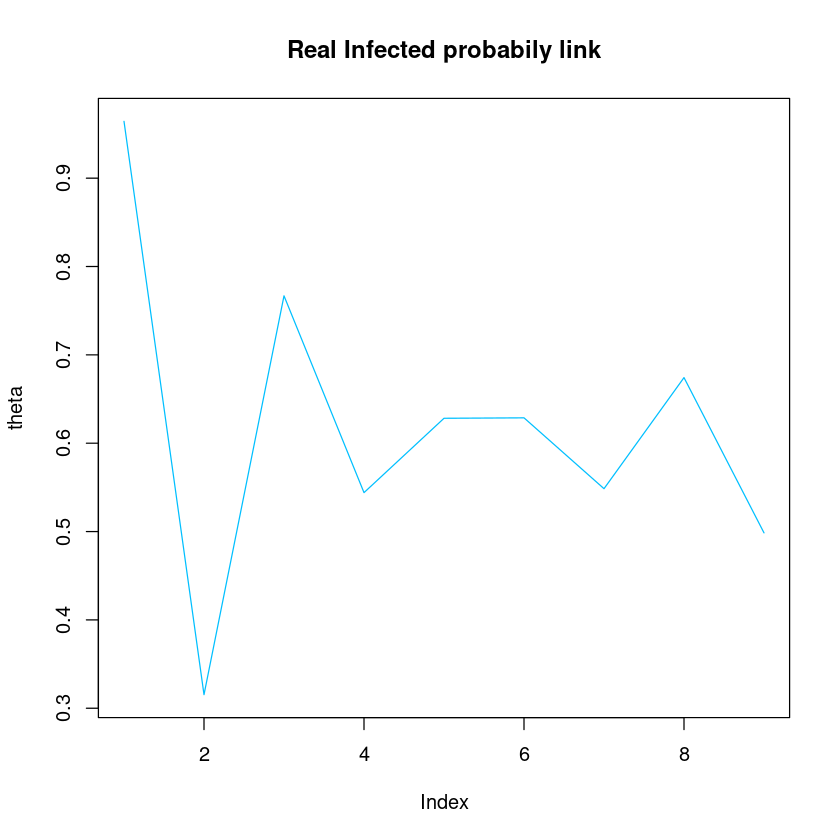

Iteration :  20

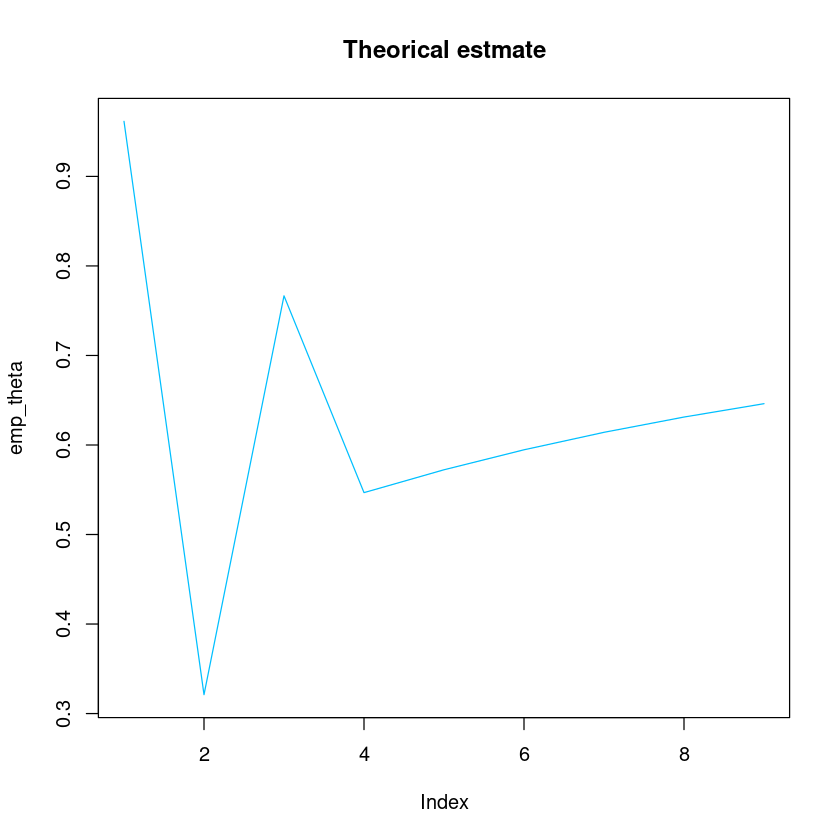

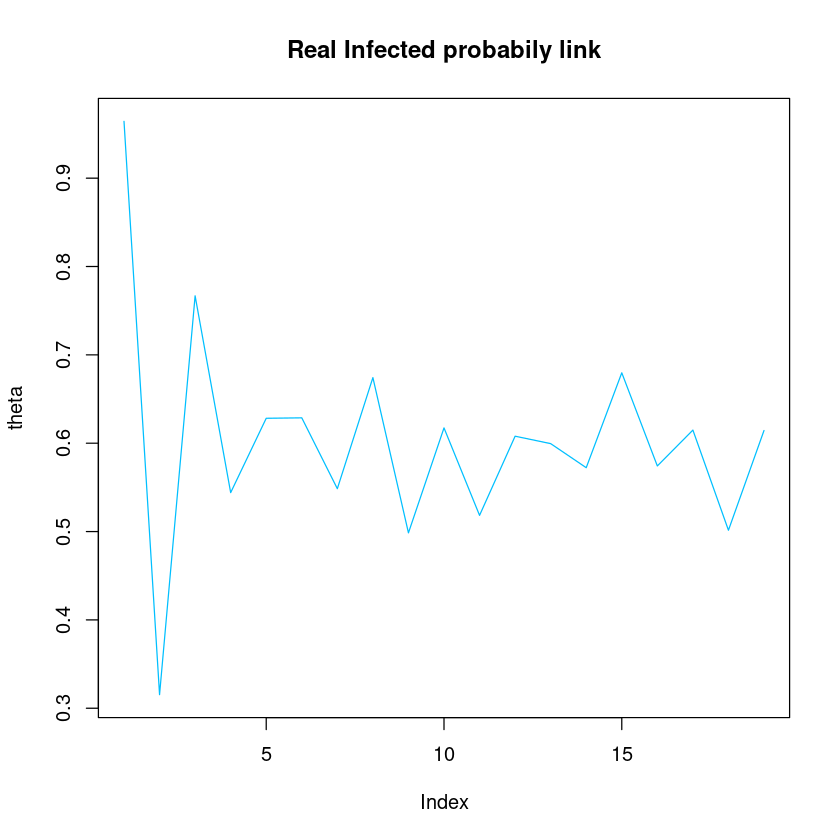

Iteration :  30

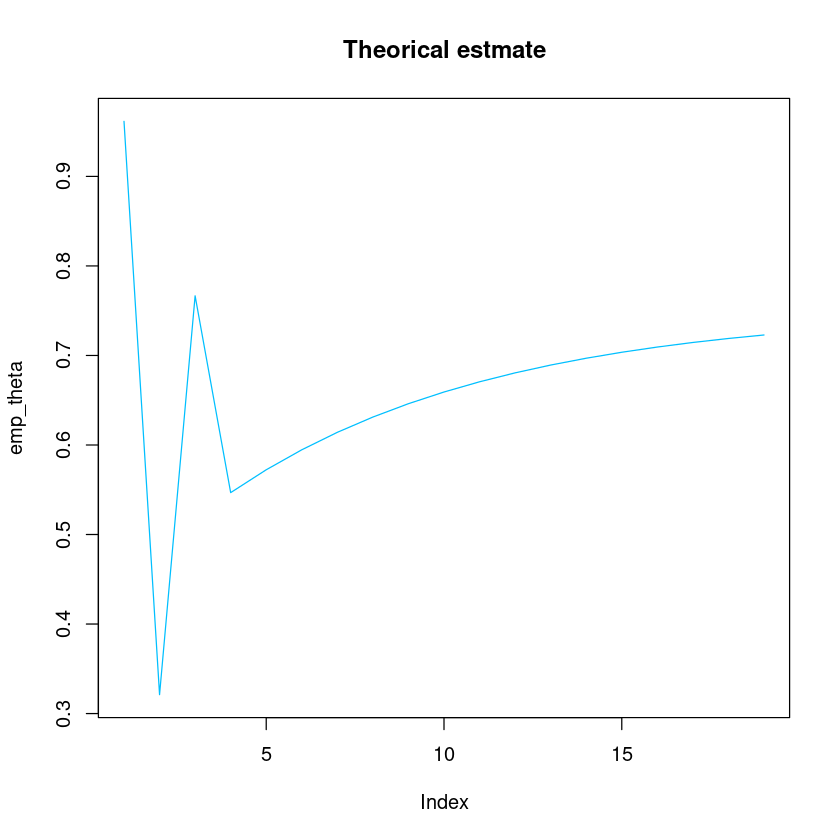

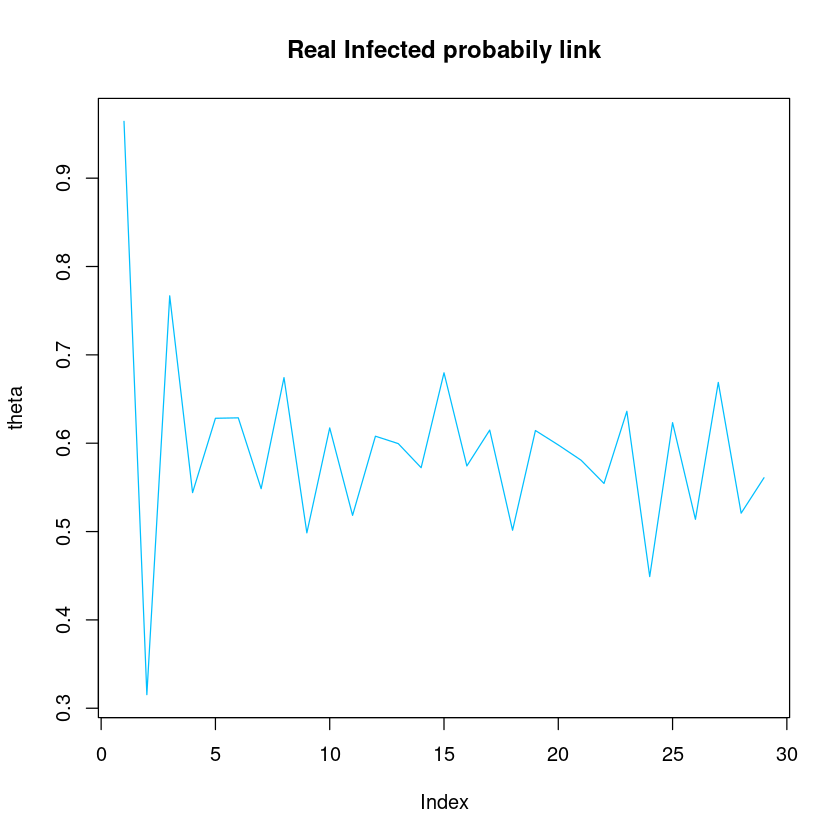

Iteration :  40

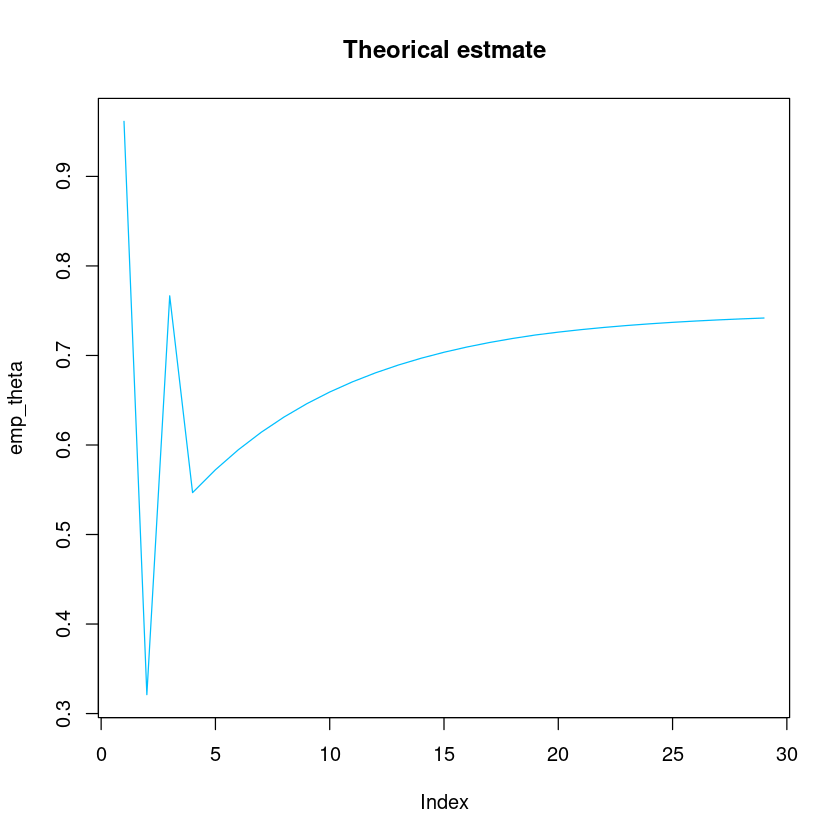

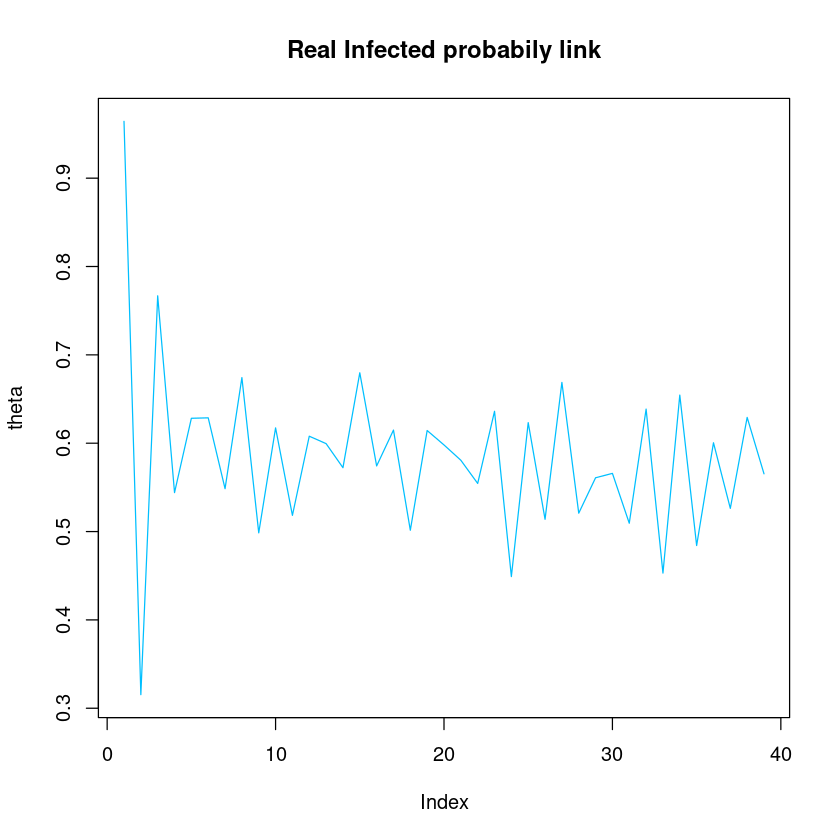

Iteration :  50

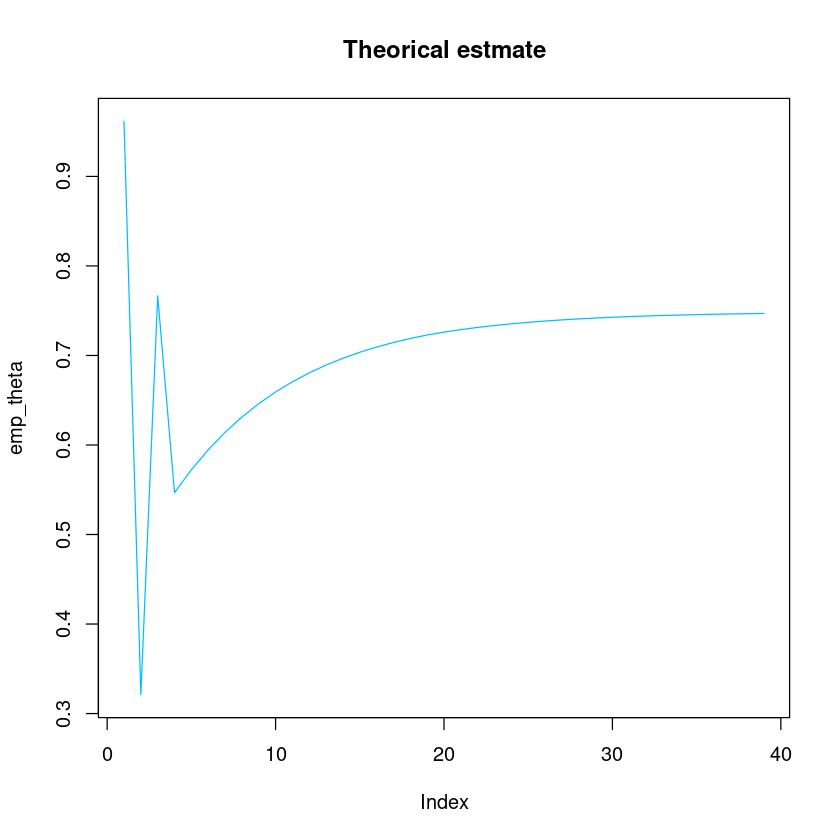

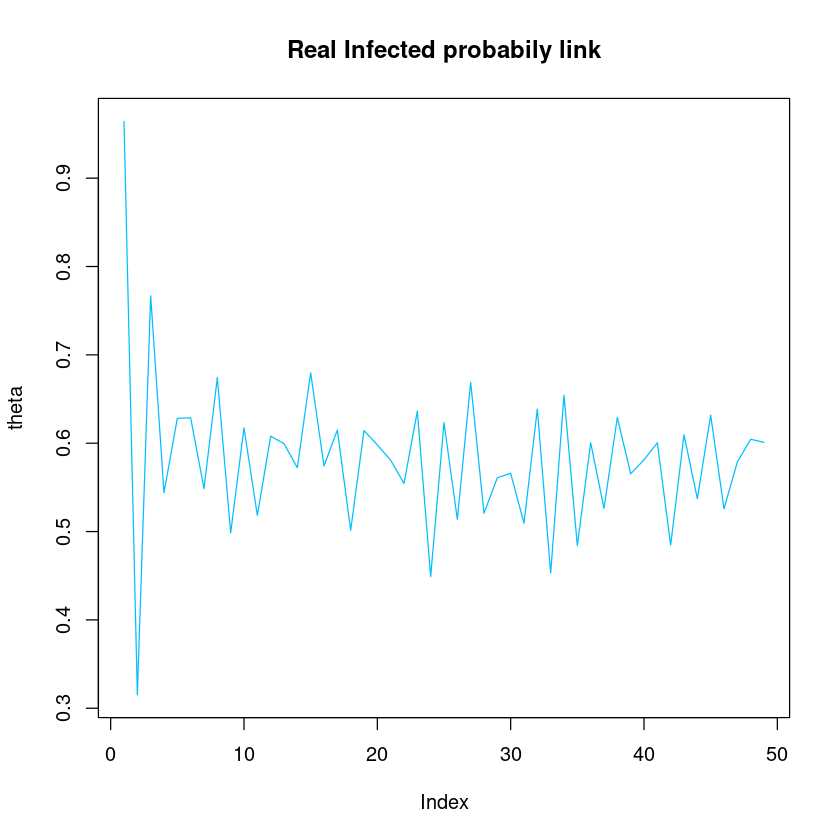

Iteration :  60

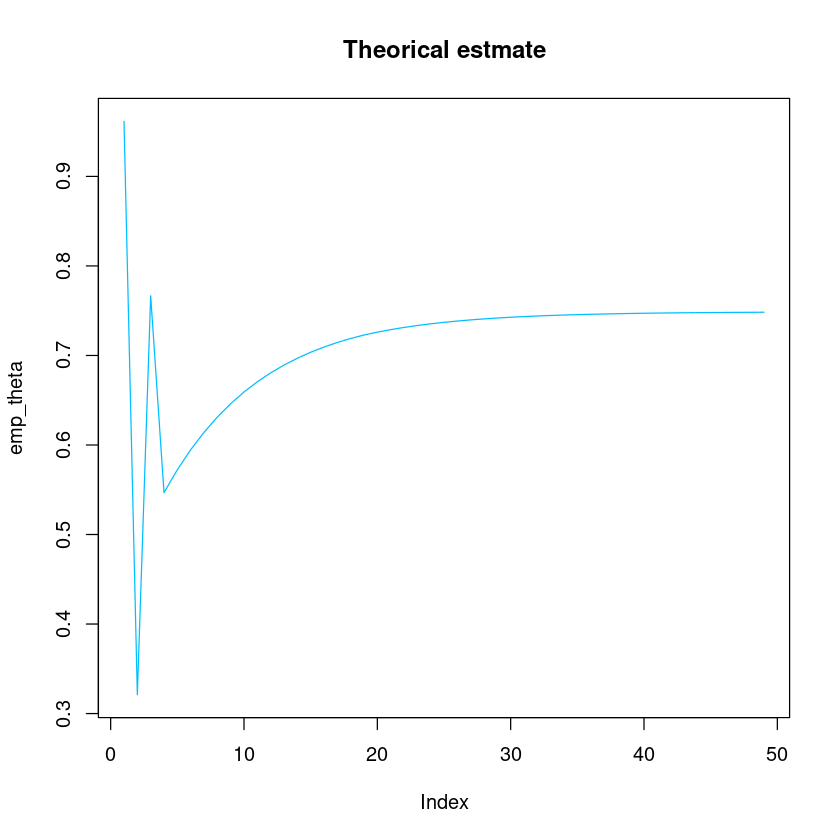

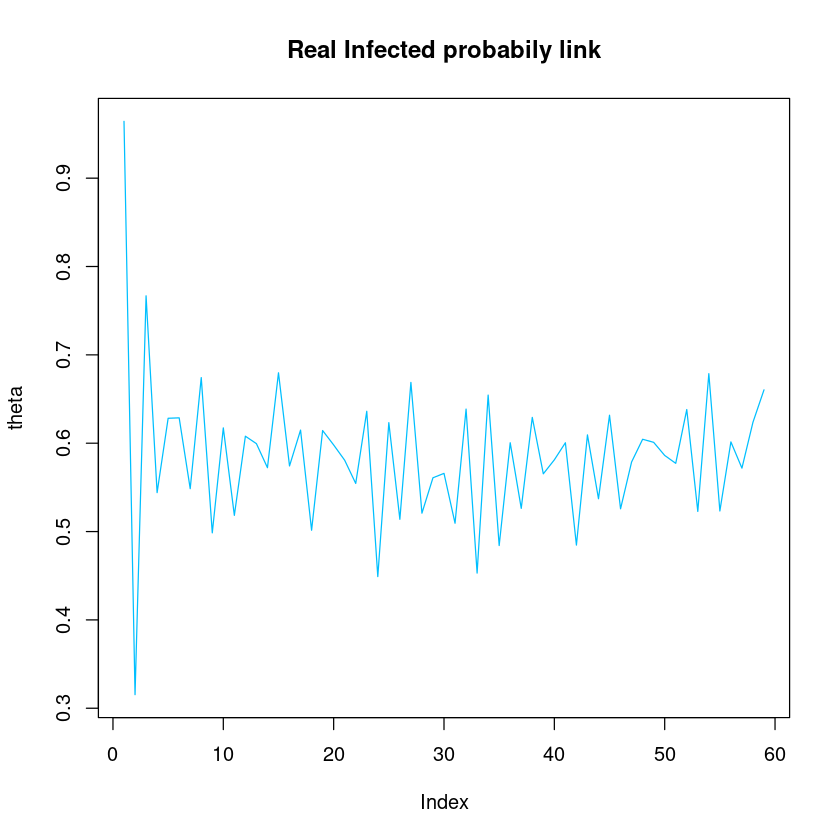

Iteration :  70

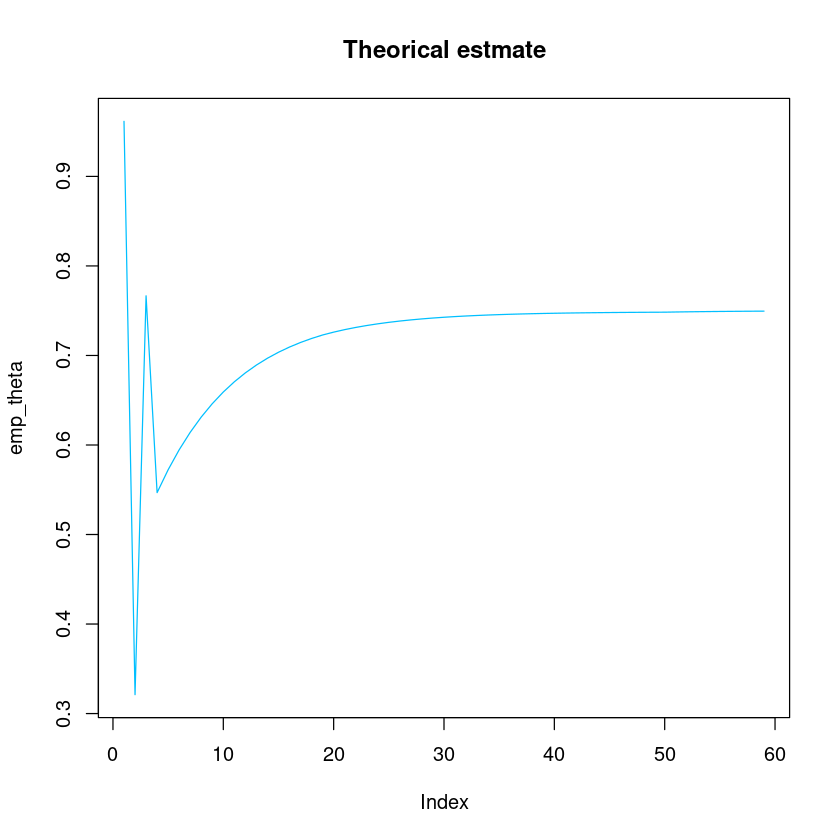

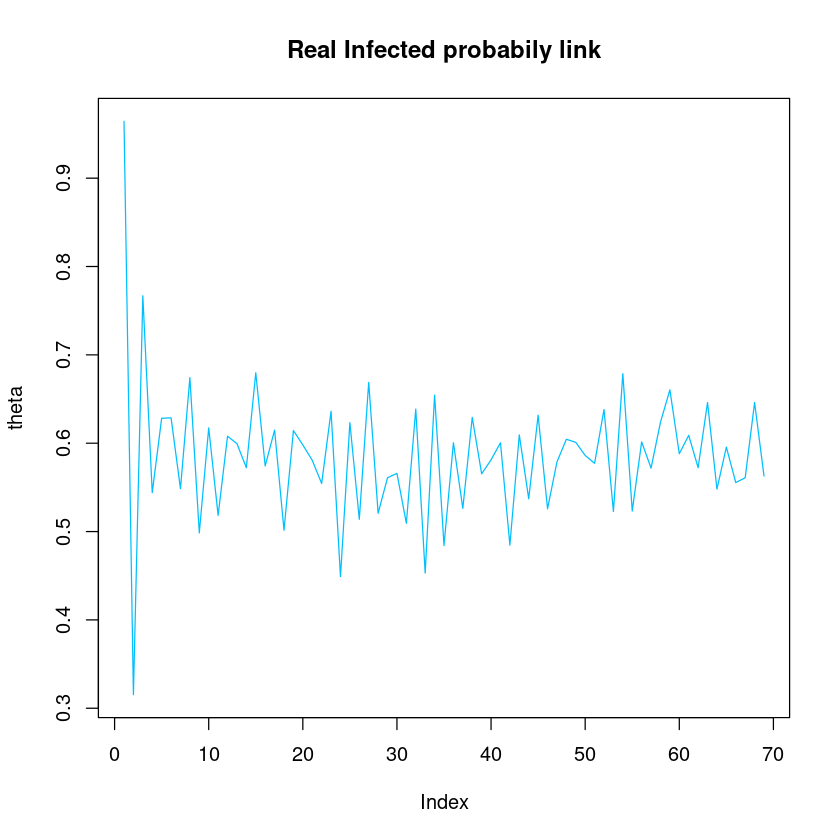

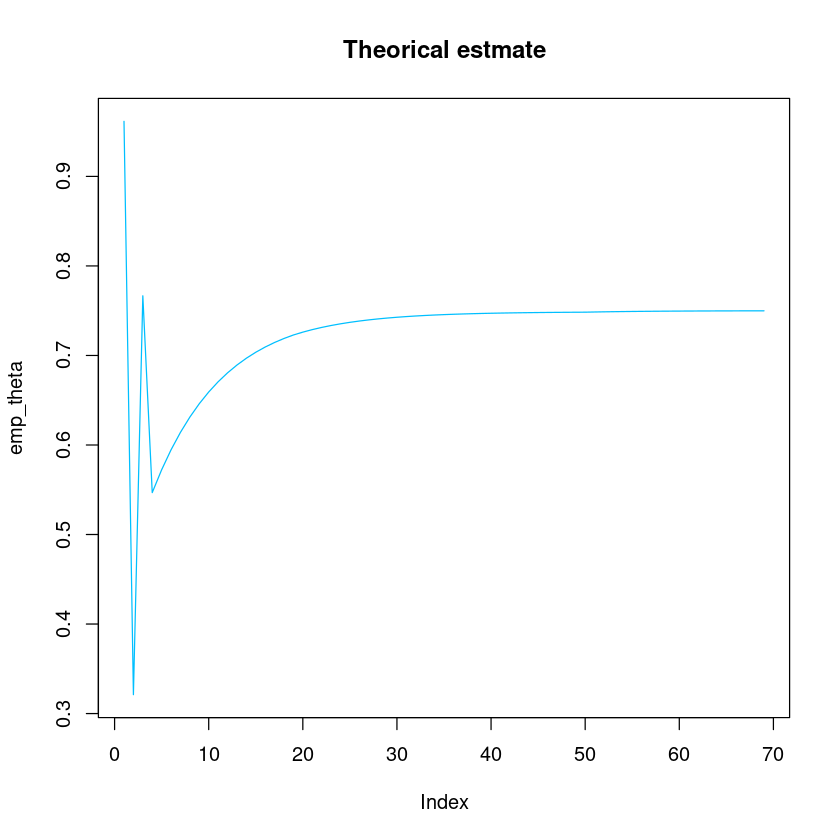

mean real infected link probability =  0.5865488
last theoretical estimate of infected link probability =  0.7498868


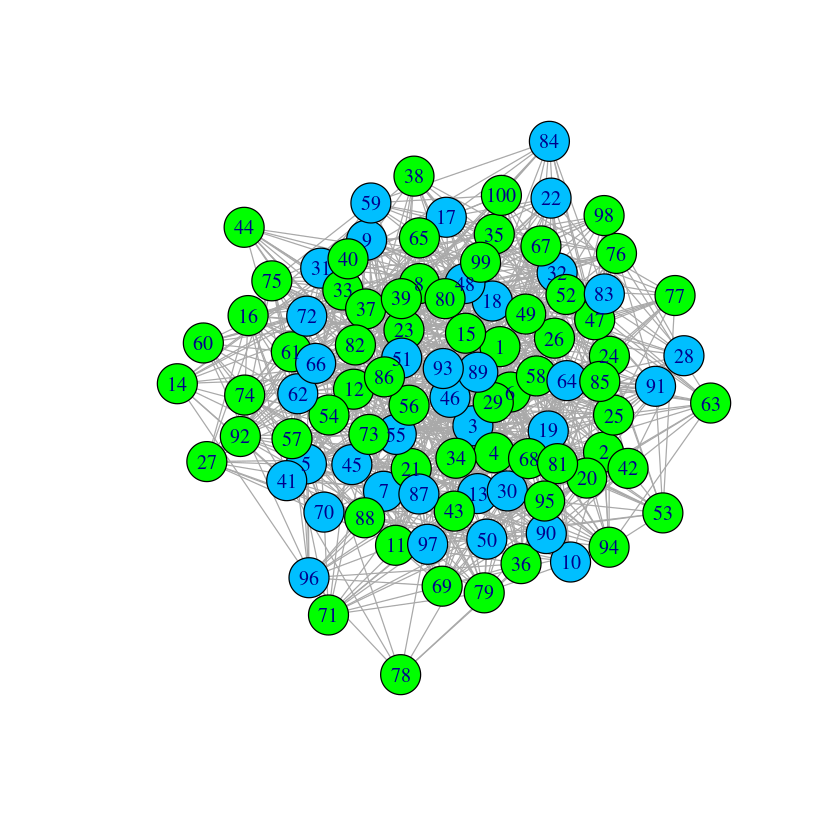

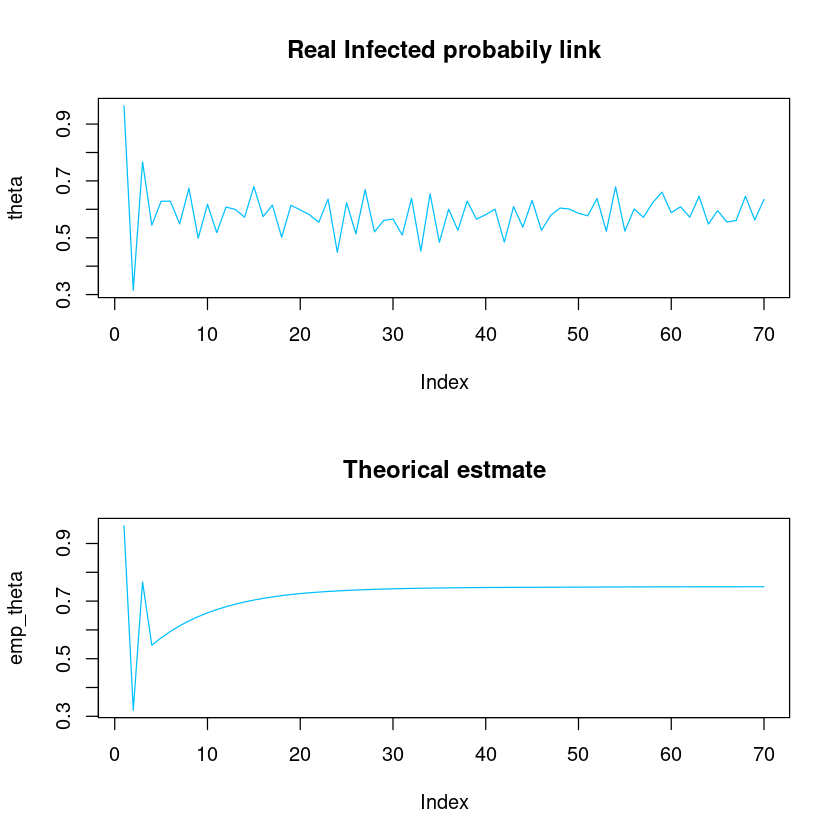

In [5]:
library(sand)

size_graph = 100;

fact <- function(n)
{
    if (n <= 1)
        return (1);

    return (n*fact(n-1));
}

binom <- function(n, m)
{
    return (fact(n)/(fact(n-m)*fact(m)));
}


get_cost_seq <- function(k)
{
    if (k < 20 || k > 50)
        return (1);
    return (10);
} 

p_01 <- function(a, k)
{
    return (min(a/get_cost_seq(k), 1));
}

emp_theta <- function(emp_ro_k, g)
{
    res = 0;
    denominator = 0;

    P_d <- get_P_d(g);
    ro_k <- emp_ro_k;
    D <- length(degree(g));

    for(d in 1:min(length(P_d), length(ro_k), D))
    {
        res = res +  d*P_d[d]*ro_k[d];
        denominator = denominator + d*P_d[d];
    }
    #print("P_d\n")
    #print(P_d)
    #print("Denominator\n")
    #print(denominator)
    #print(res)

    return (res/denominator)
}

emp_p_01 <- function(emp_ro_k, d, g, k)
{
    sum = 0;
    emp_theta <- emp_theta(emp_ro_k, g)

    for (a in 0:d)
    {
        sum = sum + p_01(a, k)*binom(d, a)*(emp_theta ** a)*
                            ((1 - emp_theta) ** (d-a));
    }
    
    return ((1-emp_ro_k[d])*sum);
}

p_10 <- function()
{
    return (1/3);
}

emp_p_10 <- function(emp_ro_k, d, g, k)
{
    sum = 0;
    emp_theta <- emp_theta(emp_ro_k, g)

    for (a in 0:d)
    {
        sum = sum + p_10()*binom(d, a)*(emp_theta ** a)*
                            ((1 - emp_theta) ** (d-a));
    }
    
    return ((emp_ro_k[d])*sum);
}

update_emp_ro_k <- function(emp_ro_k, g, k)
{
    D <- length(degree_distribution(g));
    #print(D)
    ro_k <- emp_ro_k
    #if (ro_k[size_graph - 1] > 0)
    #    exit();
    for(d in 1:D)
    {
        ro_k[d] <- ro_k[d] + (1/size_graph)*(emp_p_01(emp_ro_k, d, g, k) - 
                                        emp_p_10(emp_ro_k, d, g, k));
    }

    return (ro_k);
}

change_state <- function(A_k_m, degree, cost_seq_vert, state)
{
    if (state == 0)
        return (cost_seq_vert <= A_k_m)

    return (rbinom(1, 1, 0.3));
}

get_A_k_m <- function(adj_vector, old_infl)
{
    sum = 0;
    for (v in adj_vector)
    {
        sum  = sum + old_infl[v]
    }

    return (sum);
}

get_P_d <- function(g)
{
    return (degree_distribution(g))
}

get_ro_k <- function(g)
{
    degrees <- degree(g);
    res <- rep(0, size_graph);
    for (i in 1:size_graph)
    {
        if (g$influenced[i] == 1)
            res[degrees[i] + 1] =  res[degrees[i] + 1] + 1;
    }
    degr_distr <- size_graph*get_P_d(g);
    for (i in 1:length(degr_distr))
    {
        if (degr_distr[i] != 0)
            res[i] = res[i]/degr_distr[i];
    }

    return (res);
}

get_infected_link_prob <- function(g)
{
    res = 0;
    denominator = 0;

    P_d <- get_P_d(g);
    ro_k <- get_ro_k(g);

    for(d in 1:min(length(P_d), length(ro_k)))
    {
        res = res +  d*P_d[d]*ro_k[d];
        denominator = denominator + d*P_d[d];
    }
    #print("P_d\n")
    #print(P_d)
    #print("Denominator\n")
    #print(denominator)
    #print(res)

    return (res/denominator)
}

update_states <- function(g, k)
{
    cost_seq <- runif(size_graph, 0, get_cost_seq(k));
    for (i in 1:size_graph)
    {
        adj_v <- adjacent_vertices(g, i)
        adj_vector <- adj_v[[1]]
        A_k_m <- get_A_k_m(adj_vector,  g$influenced)
        state <- change_state(A_k_m, degree(g)[i], cost_seq[i], 
                                        g$influenced[i]);
        g$influenced[i] <- state;
    }

    return (g)
}

main <- function(warm_index, n_iteration, proba_er, proba_inf = 0.05, freq = 10,
                            steps_on_iter = 10)
{
    set.seed(42)
    proba <- vector()
    g.er <- erdos.renyi.game(size_graph, proba_er)

    influenced <- rbinom(size_graph, 1, proba_inf);
    g.er$influenced <- influenced
    
    ro_k <- get_ro_k(g.er);
    theta <- vector() 
    emp_theta <- vector();
    for(k in 1:n_iteration)
    {
        g.er <- update_states(g.er, k)

        g.er.colors <- as.character(length(influenced));
        g.er.colors[g.er$influenced == 1] <- "green";
        g.er.colors[g.er$influenced == 0] <- "deepskyblue";
        influenced <- update_influenced(g.er, influenced)
        proba[k] <- sum(g.er$influenced)/size_graph;
        if (k %% freq == 0)
        {
            #plot(g.er, layout=layout.fruchterman.reingold,
            #        vertex.color=g.er.colors)
            
            #text(-1.2, 1, "green is infected\n blue is not infected")
            cat("Iteration : ", k);
            plot(theta, main = "Real Infected probabily link",
                 col = "deepskyblue", type = "l")
            plot(emp_theta, main = "Theorical estmate",
                 col = "deepskyblue", type = "l")
        }
        #print(g.er$influenced)
        if (k <= warm_index) 
        {
            emp_ro_k <- update_emp_ro_k(get_ro_k(g.er), g.er, k);
        }
        if (k > warm_index) 
        {
            for (i in 1:steps_on_iter)
            {
                emp_ro_k <- update_emp_ro_k(emp_ro_k, g.er, k);
                i <- i + 1;
            }
        } 
        emp_theta[k] <- emp_theta(emp_ro_k, g.er);
        #plot(emp_ro_k)
            
         
        theta[k] <- get_infected_link_prob(g.er);
    }
    
    plot(g.er, layout=layout.fruchterman.reingold,
            vertex.color=g.er.colors)
     
    text(-2, 1, "green is infected\n blue is not infected")
    
    cat("mean real infected link probability = ", mean(theta))
    cat("\n")
    cat("last theoretical estimate of infected link probability = ", emp_theta[n_iteration])
    cat("\n")
    
    par(mfrow = (c(2, 1)))
    plot(theta, main = "Real Infected probabily link",
         col = "deepskyblue", type = "l")
    plot(emp_theta, main = "Theorical estmate",
                col = "deepskyblue", type = "l")
           
#write update influenced and recalculate smth properties of graph
}

update_influenced <- function(g, old_infl)
{
    inf_distr <- rep(0, size_graph)
    
    for (i in 1:size_graph)
        inf_distr[i] <- 0
    new_influenced <- old_infl;
    for (i in 1:size_graph)
    {
        sum = 0;
        adj_v <- adjacent_vertices(g, i)
        adj_vector <- adj_v[[1]]
        A_k_m <- get_A_k_m(adj_vector, old_infl)
    }
    max_degree <- length(degree_distribution(g))
    res = c(1:size_graph);
    for(i in 1:max_degree)
    {
        res[i] = 0;
        if (degree_distribution(g)[i] != 0)
            res[i] = inf_distr[i]/(size_graph*degree_distribution(g)[i])
    }

    return (res)
}

main(warm_index = 4, n_iteration = 70, proba_er = 0.2, proba_inf = 0.05, freq = 10,
                                steps_on_iter = 10);